In [1]:
import sqlite3
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [3]:
values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0

    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue

    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])
    cena = float(row[16])

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

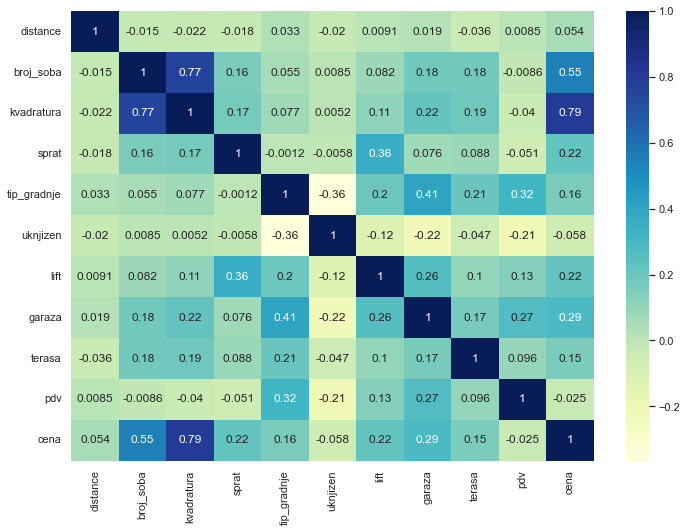

In [4]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv', 'cena']
df = pd.DataFrame(full_data, columns=header)
price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
categories = [0,1,2,3,4,5]
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


In [5]:
df['cena'] = pd.cut(df['cena'], bins=price_ranges, labels=categories)
df.head()

,distance,broj_soba,kvadratura,sprat,tip_gradnje,uknjizen,lift,garaza,terasa,pdv,cena
0,39.127679,3.0,68.0,1.000000,0,1.0,1.0,0.0,1.0,0.0,3
1,35.570932,2.5,75.0,3.459432,0,1.0,1.0,0.0,1.0,0.0,3
2,34.167384,3.0,69.0,2.000000,1,1.0,1.0,1.0,1.0,0.0,4
3,37.692401,4.0,146.0,4.169925,1,0.0,1.0,1.0,1.0,0.0,5
4,37.751948,4.0,125.0,2.000000,0,1.0,1.0,0.0,1.0,0.0,4


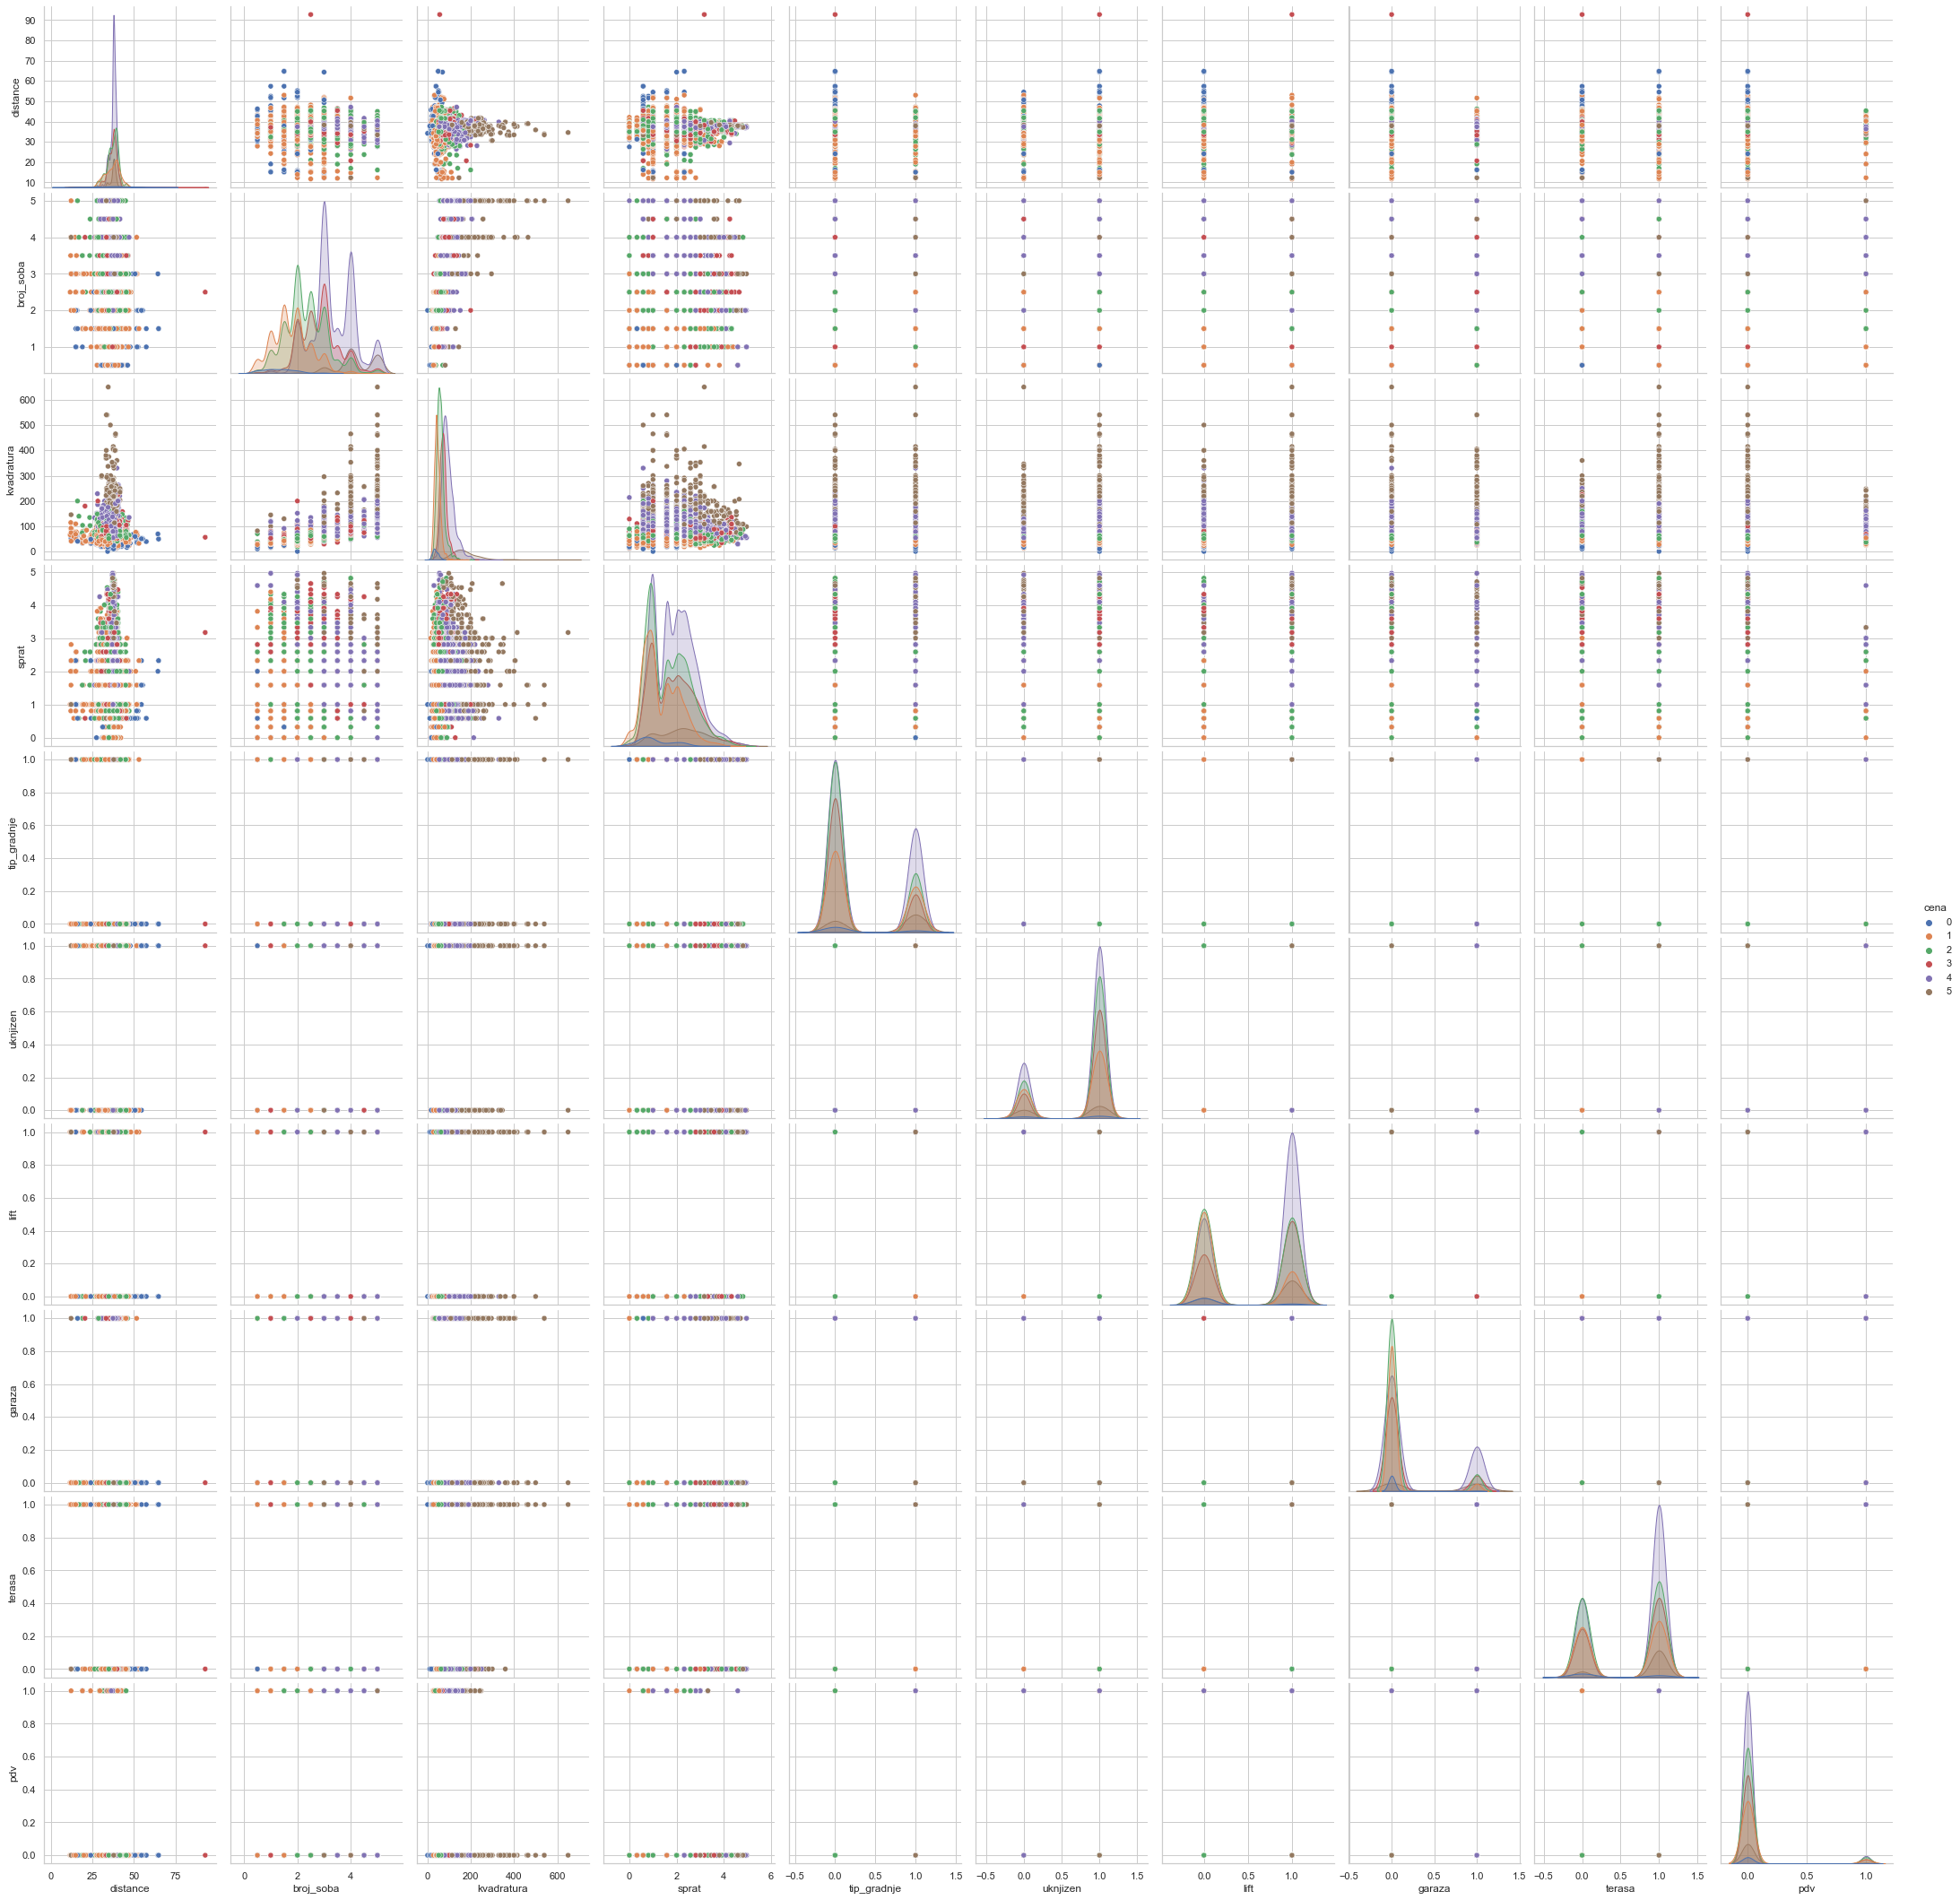

In [6]:
plt.close()
sns.set_style('whitegrid')
sns.pairplot(df, hue='cena', height=3)
plt.show()

In [17]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df['cena']
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X_data)
print(y_data)

0        3
1        3
2        4
3        5
4        4
        ..
11979    4
11980    2
11981    2
11982    2
11983    5
Name: cena, Length: 11984, dtype: category
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


In [8]:
def knn_acc_score(X_train, y_train, X_test, y_test, n_neighbors):
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [9]:

# header_i = [x for x in header_i if x != 'kvadratura']
# temp_header.append('kvadratura')
def knn_wrapper(X_train, X_test, y_train, y_test, header, n_neighbors):
    temp_header = list()
    acc_list = list()
    header_i = header.copy()
    best_score_list = list()
    
    df_train = pd.DataFrame(X_train, columns=header)
    df_test = pd.DataFrame(X_test, columns=header)
    while len(header_i)>0:
        best_score = 0
        for elem in header_i:
            new_header = temp_header.copy()
            new_header.append(elem)
            X_train_temp = df_train.loc[:, new_header].values.tolist()
            X_test_temp = df_test.loc[:, new_header].values.tolist()
            temp_score = knn_acc_score(X_train_temp, y_train, X_test_temp, y_test, n_neighbors)
            if temp_score > best_score:
                best_elem = elem
                best_score = temp_score.copy()
        temp_header.append(best_elem)
        best_score_list.append(best_score)
        header_i = [x for x in header_i if x != best_elem]
    return temp_header, best_score_list

In [14]:
k_knn = [1, 2, 3, 5]
acc_score = list()
column_importance = list()
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state = 1)
# X_train = MinMaxScaler.fit_transform(X_train)
# X_test = MinMaxScaler.fit_transform(X_test)
for k in k_knn:
    column, score = knn_wrapper(X_train, X_test, y_train, y_test, header, k)
    acc_score.append(score)
    column_importance.append(column)

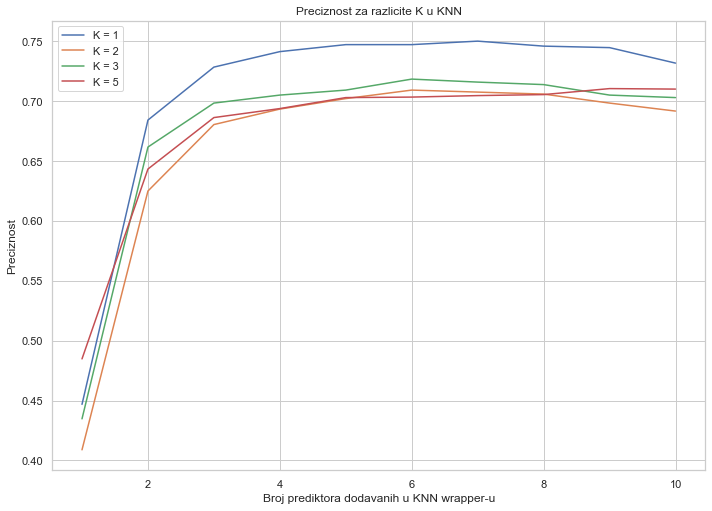

In [15]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Plotting the lines
for score, k in zip(acc_score,k_knn) :
    plt.plot(x,score, label='K = '+ str(k))


# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('Broj prediktora dodavanih u KNN wrapper-u')
plt.ylabel('Preciznost')
plt.title('Preciznost za razlicite K u KNN')

# Display the plot
plt.show()


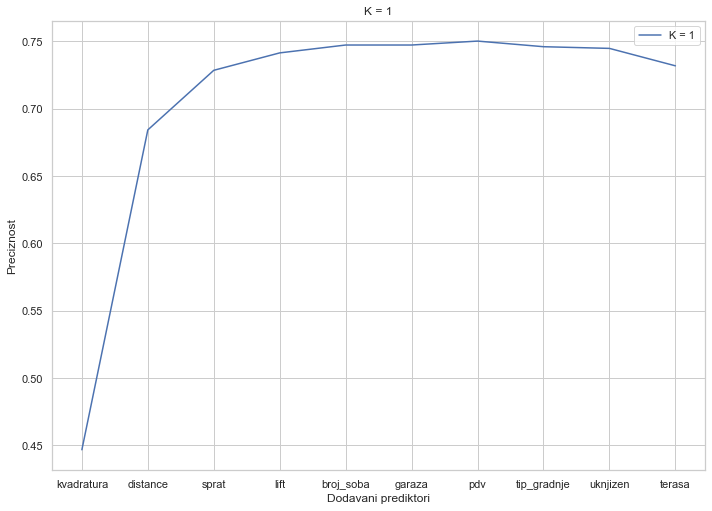

In [16]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state = 1)
# X_train = MinMaxScaler.fit_transform(X_train)
# X_test = MinMaxScaler.fit_transform(X_test)
column, score = knn_wrapper(X_train, X_test, y_train, y_test, header, 1)
plt.plot(column,score, label="K = 1")
plt.legend()
plt.xlabel('Dodavani prediktori')
plt.ylabel('Preciznost')
plt.title('K = 1')
plt.show()


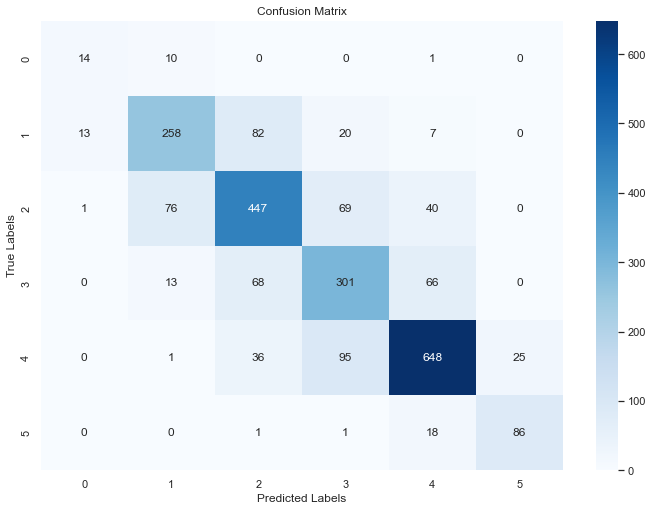

ACCURACY:  0.7317480183562787


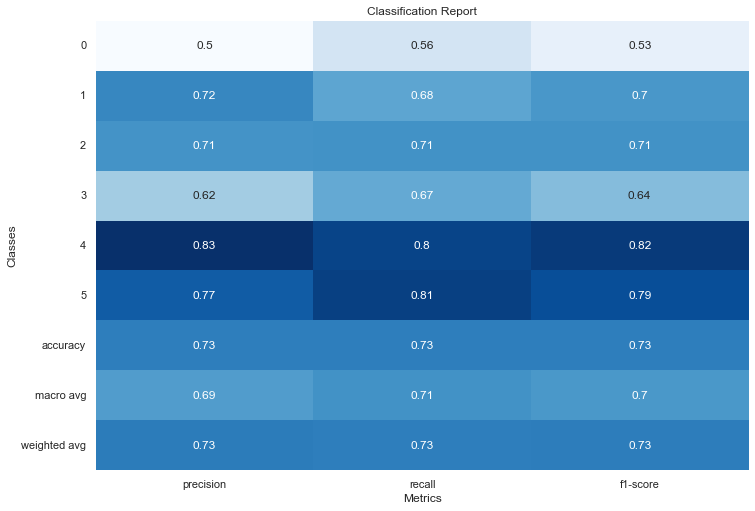

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state = 1)
knn_clf=KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test)
result = confusion_matrix(y_test, ypred)
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()
result1 = classification_report(y_test, ypred, output_dict=True)
report_df = pd.DataFrame(result1)

# Create a heatmap using Seaborn
sns.heatmap(report_df.iloc[:-1, :].astype(float).transpose(), annot=True, cmap='Blues', cbar=False)

# Set labels and title
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.title('Classification Report')
result2 = accuracy_score(y_test,ypred)
print("ACCURACY: ",result2)